In [1]:
!pip3 install -U segmentation-models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 5.4 MB/s eta 0:00:00


In [30]:
!pip install -U -q segmentation-models
!pip install -q tensorflow==2.2.1
!pip install -q keras==2.5
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models as sm

ERROR: Could not find a version that satisfies the requirement tensorflow==2.2.1 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.13.0rc0, 2.13.0rc1)
ERROR: No matching distribution found for tensorflow==2.2.1
ERROR: Could not find a version that satisfies the requirement keras==2.5 (from versions: 0.2.0, 0.3.0, 0.3.1, 0.3.2, 0.3.3, 1.0.0, 1.0.1, 1.0.2, 1.0.3, 1.0.4, 1.0.5, 1.0.6, 1.0.7, 1.0.8, 1.1.0, 1.1.1, 1.1.2, 1.2.0, 1.2.1, 1.2.2, 2.0.0, 2.0.1, 2.0.2, 2.0.3, 2.0.4, 2.0.5, 2.0.6, 2.0.7, 2.0.8, 2.0.9, 2.1.0, 2.1.1, 2.1.2, 2.1.3, 2.1.4, 2.1.5, 2.1.6, 2.2.0, 2.2.1, 2.2.2, 2.2.3, 2.2.4, 2.2.5, 2.3.0, 2.3.1, 2.4.0, 2.4.1, 2.4.2, 2.4.3, 2.5.0rc0, 2.6.0rc0, 2.6.0rc1, 2.6.0rc2, 2.6.0rc3, 2.6.0, 2.7.0rc0, 2.7.0rc2, 2.7.0, 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.9.0rc0, 2.9.0rc1, 2.9.0

In [2]:
import json
with open('/content/drive/MyDrive/ocelot2023_v0.1.2/metadata.json') as file:
    data = json.load(file)


In [48]:
import numpy as np
import cv2

image=cv2.imread('/content/drive/MyDrive/ocelot2023_v0.1.2/images/train/tissue/001.jpg')
# Assuming you have your image stored in the variable "image"
# Convert the image to a numpy array
images = np.array(image)



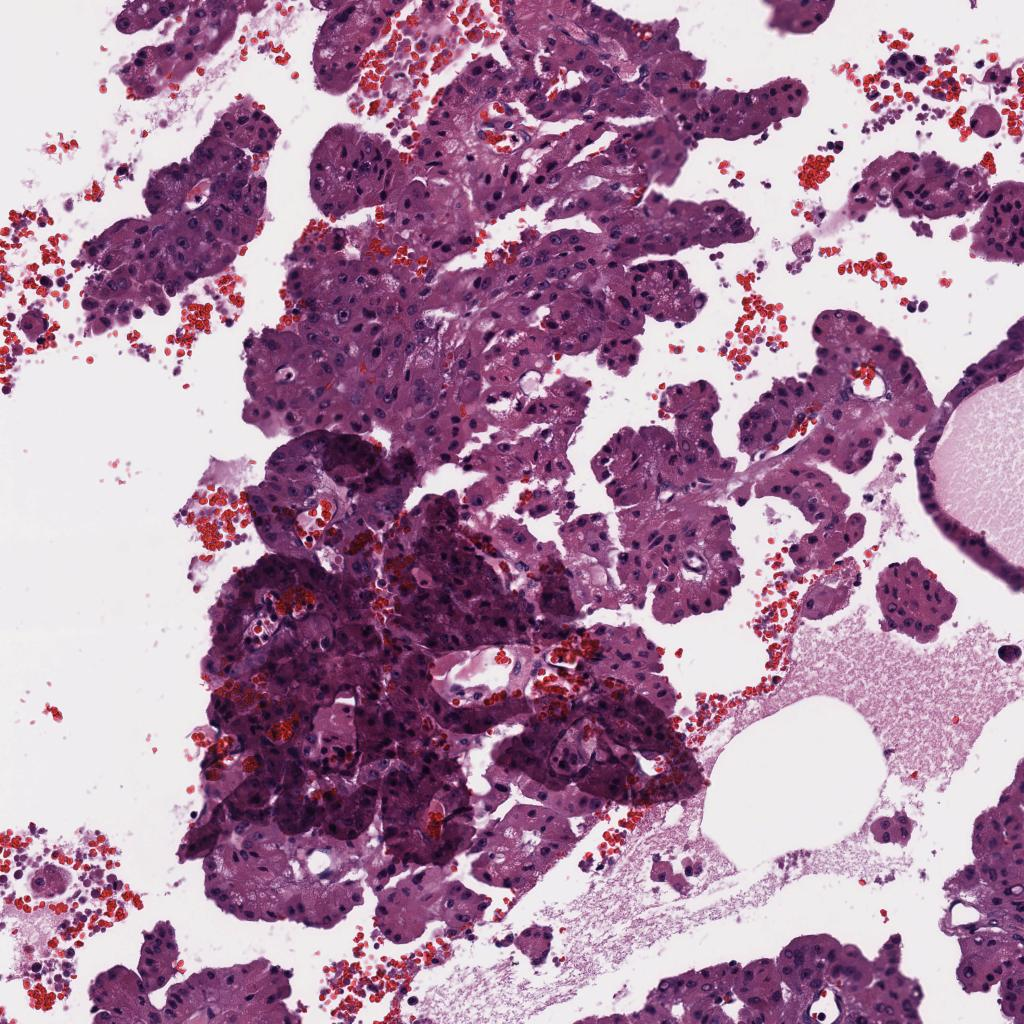

In [49]:
from google.colab.patches import cv2_imshow
cv2_imshow(image)

In [50]:
import numpy as np

def crop_img(img, size, stride):
    # This function crops an image using the sliding window technique. Size is the patch size of the sliding window and stride is the stride of the sliding window patches.
    cropped_img = []
    size_x = img.shape[1]
    size_y = img.shape[0]
    x = np.arange(0, size_x, stride)
    y = np.arange(0, size_y, stride)
    x = [i for i in x if i+size <= size_x]
    y = [i for i in y if i+size <= size_y]
    x.append(size_x - size)
    y.append(size_y - size)
    x = np.unique(x)
    y = np.unique(y)
    for i in x:
        for j in y:
            cropped_img.append(img[j:j+size, i:i+size])
    return cropped_img


In [51]:
patches = crop_img(image, size=256, stride=256)


In [52]:
patches

[array([[[237, 236, 238],
         [237, 236, 238],
         [237, 236, 238],
         ...,
         [ 94,  53, 121],
         [ 98,  57, 125],
         [104,  63, 130]],
 
        [[237, 236, 238],
         [237, 236, 238],
         [237, 236, 238],
         ...,
         [ 93,  52, 120],
         [ 96,  55, 123],
         [102,  61, 128]],
 
        [[237, 236, 238],
         [237, 236, 238],
         [237, 236, 238],
         ...,
         [ 95,  51, 120],
         [ 93,  52, 120],
         [ 97,  56, 123]],
 
        ...,
 
        [[ 36,  22, 177],
         [ 43,  30, 175],
         [ 75,  62, 190],
         ...,
         [238, 234, 240],
         [236, 234, 240],
         [237, 235, 241]],
 
        [[ 46,  44, 194],
         [ 63,  61, 204],
         [ 93,  89, 215],
         ...,
         [239, 236, 238],
         [237, 236, 238],
         [236, 238, 239]],
 
        [[ 62,  61, 194],
         [ 58,  57, 183],
         [ 76,  73, 189],
         ...,
         [240, 237, 239],
  

In [32]:
# this function creates the segmentation model by adding a dropout layer before the output softmax layer.
# different backbones can be used. num_classes is the number of classes to segment. One can change the input patch size as well.
# model_dp is the segmentation model to train. preprocess_input is the preprocessing input for the input patches to the model. In case of InceptionV3 this function
# rescales the input patches from [0,256] to [-1,1].

import tensorflow
import segmentation_models as sm
sm.set_framework('tf.keras')

BACKBONE = 'inceptionv3'
activation='softmax'
encoder_freeze = False
num_classes = 2

preprocess_input = sm.get_preprocessing(BACKBONE)
def model(dropout_value):
    preprocess_input = sm.get_preprocessing(BACKBONE)
    model = sm.Unet(BACKBONE,
                    input_shape = (256,256,3),
                    encoder_weights='imagenet',
                    classes=num_classes,
                    activation=activation,
                    encoder_freeze = encoder_freeze)
    model.summary()
    model_input = model.input
    model_output = model.get_layer('final_conv').output
    model_output = tensorflow.keras.layers.Dropout(dropout_value)(model_output)
    output = tensorflow.keras.layers.Activation(activation, name=activation)(model_output)
    model_dp = tensorflow.keras.models.Model(model_input, output)
    return model_dp, preprocess_input

In [33]:
dropout_value = 0.4  # Example dropout value
model_dp, preprocess_input = model(dropout_value)

model_dp.load_weights('/content/drive/MyDrive/inceptionv3_256_both_angle_dropout_point4_all-05.hdf5')




87910968/87910968 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 32  96         ['conv2d[0][0]']                 
 alization)                  

In [44]:
preprocessed_images = []
for patches in patches:
    preprocessed_image = preprocess_input(patches)
    preprocessed_images.append(preprocessed_image)



In [55]:
preprocessed_images = []
for patches in patches:
    preprocessed_image = preprocess_input(patches)
    preprocessed_image = preprocessed_image[np.newaxis, ...]  # Add an extra dimension
    preprocessed_images.append(preprocessed_image)

preprocessed_images = np.concatenate(preprocessed_images, axis=0)


In [56]:
preprocessed_images.shape

(16, 256, 256, 3)

In [57]:
preprocessed_images = np.stack(preprocessed_images, axis=0)
preprocessed_images.shape

(16, 256, 256, 3)

In [58]:
predictions = model_dp.predict(preprocessed_images)


1/1 [==============================] - 9s 9s/step


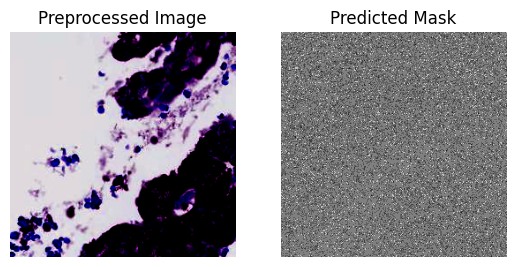

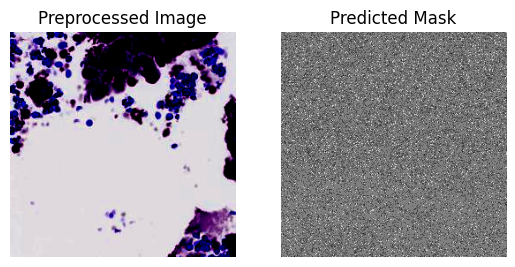

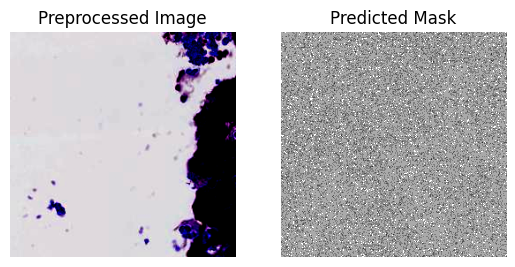

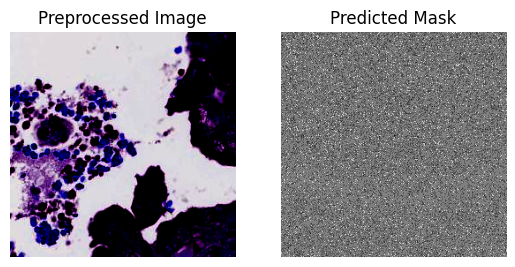

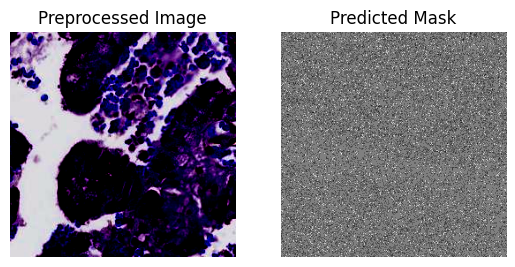

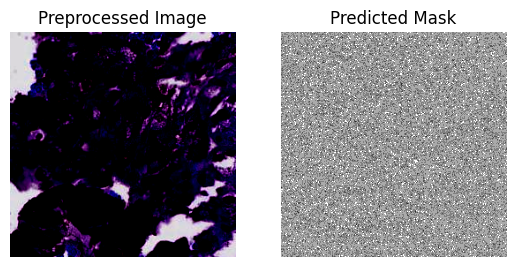

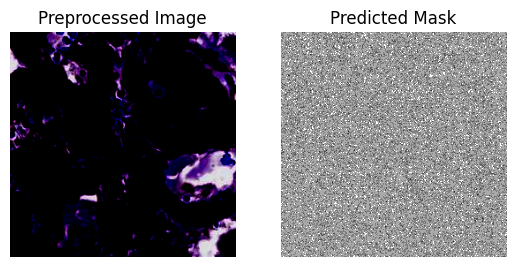

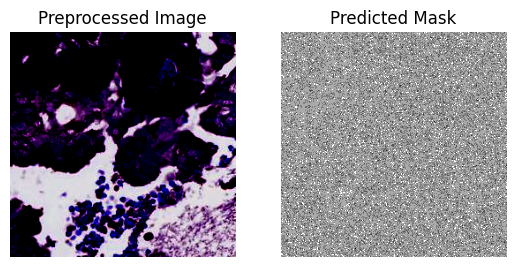

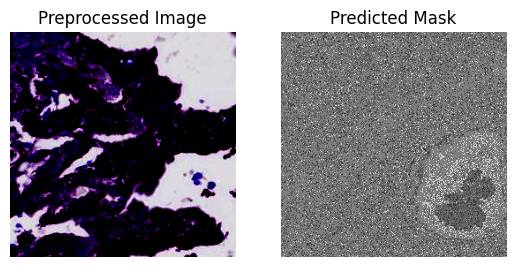

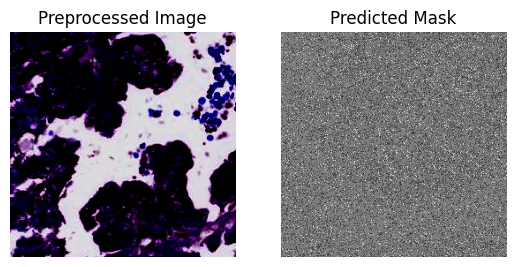

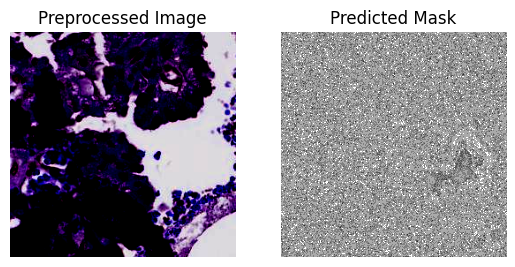

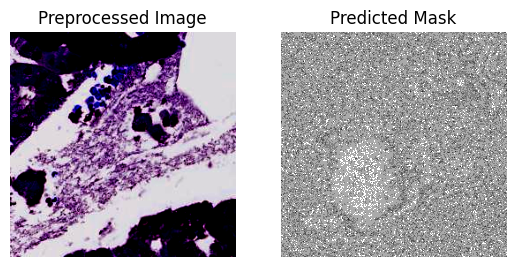

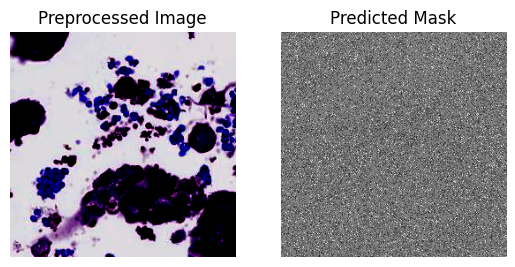

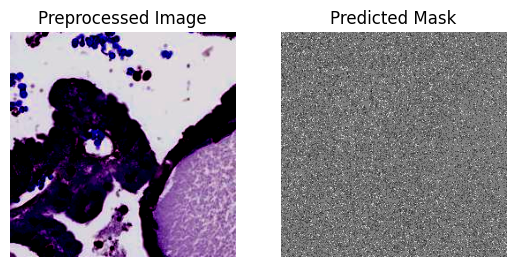

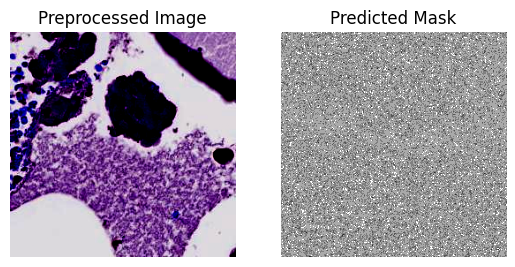

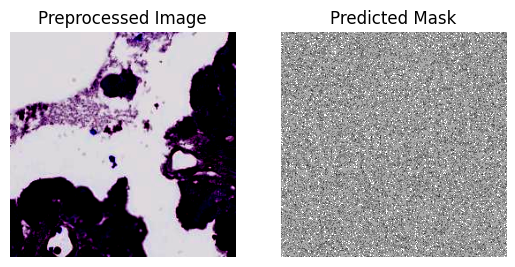

In [61]:
import matplotlib.pyplot as plt

# Assuming you have the preprocessed images stored in the variable 'preprocessed_images'
# Assuming you have the predictions stored in the variable 'predictions'

# Iterate over each prediction
for i in range(len(preprocessed_images)):
    # Get the preprocessed image and its corresponding prediction
    preprocessed_image = preprocessed_images[i]
    prediction = predictions[i]

    # Convert prediction to single-channel grayscale mask
    grayscale_mask = np.sum(prediction, axis=-1)

    # Plot the preprocessed image
    plt.subplot(1, 2, 1)
    plt.imshow(preprocessed_image)
    plt.axis('off')
    plt.title('Preprocessed Image')

    # Plot the grayscale mask
    plt.subplot(1, 2, 2)
    plt.imshow(grayscale_mask, cmap='gray')
    plt.axis('off')
    plt.title('Predicted Mask')

    # Show the plot for each prediction
    plt.show()


In [63]:
import numpy as np

# Assuming you have the predictions stored in the variable 'predictions'

# Join the predicted patches back into the original image size
num_patches = int(1024 / 256)  # Number of patches in each dimension
patch_size = 256

# Reshape the predictions array to (num_patches, num_patches, patch_size, patch_size)
predictions_reshaped = np.reshape(predictions, (num_patches, num_patches, patch_size, patch_size))

# Create an empty array for the reconstructed mask
reconstructed_mask = np.zeros((1024, 1024))

# Fill in the reconstructed mask with the predicted patches
for i in range(num_patches):
    for j in range(num_patches):
        x_start = i * patch_size
        x_end = x_start + patch_size
        y_start = j * patch_size
        y_end = y_start + patch_size
        reconstructed_mask[x_start:x_end, y_start:y_end] = predictions_reshaped[i, j]

# Visualize the reconstructed mask
plt.imshow(reconstructed_mask, cmap='gray')
plt.axis('off')
plt.title('Reconstructed Mask')
plt.show()


ValueError: ignored